# Importing

In [15]:
import pandas as pd
import numpy as np
import os

import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.display import display
import re

# for load the data pre-preparation function
import importlib.util

# for report
import ipywidgets as widgets
from io import BytesIO


import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(suppress=False)

work_dir = r'C:\Users\krasavica\Desktop\Projekty - DS\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# loading functions from the file
module_name = f"pipeline_pre-processing"
module_path = f"pipeline_pre-processing.py"

spec = importlib.util.spec_from_file_location(module_name, module_path)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [4]:
data_initial = pd.read_csv('data_2024-01.csv', index_col = 0)
data_for_analysis = module.preliminary_transform(data_initial, True)

All the categorizations occurring in the set in multi-vector selection variables were coded.


# Aparment information

In [5]:
def data_for_showing(data_initial, data_transformed):
    pop_numb_cat_dict = {1: "poniżej 10 tys. osób",
                         2: "powyżej 10 tys. osób",
                         3: "powyżej 20 tys. osób",
                         4: "powyżej 50 tys. osób",
                         5: "powyżej 100 tys. osób",
                         6: "powyżej 250 tys. osób",
                         7: "powyżej 500 tys. osób",
                         8: "powyżej 1 mln osób"}
    
    pop_dens_cat_dict = {0: "poniżej 500 osób/m2",
                         1: "powyżej 500 osób/m2",
                         2: "powyżej 1 000 osób/m2",
                         3: "powyżej 1 500 osób/m2",
                         4: "powyżej 2 000 osób/m2",
                         5: "powyżej 2 500 osób/m2",
                         6: "powyżej 3 000 osób/m2",
                         7: "powyżej 3 500 osób/m2"}
    
    address_text = data_initial["address"]
    if len(address_text) >= 35:
        comma_index = address_text.rfind(",", 0, 35)
        if comma_index != -1:
            address_text = address_text[:comma_index + 1] + "\n" + address_text[comma_index + 2:]
    
    pop_numb_cat_text = pop_numb_cat_dict[data_transformed["pop_numb_cat"]]
    pop_dens_cat_text = pop_dens_cat_dict[data_transformed["pop_dens_cat"]]
    area_text = f'{data_initial["area"]} m2'
    num_rooms_text = data_initial["num_rooms"]
    floor_text = data_initial["floor"]
    market_text = data_initial["market"]
    flat_condition_text = data_initial["flat_condition"]
    devel_type_text = data_initial["devel_type"]
    year_text = int(data_initial["year"])
    heating_text = data_initial["heating"]
    
    labels = ["Adres", "Liczba mieszkańców", "Gęstość zaludnienia", "Powierzchnia",
              "Liczba pokoi", "Piętro", "Rynek", "Stan wykończenia", "Typ zabudowy", 
              "Rok budynku", "Ogrzewanie"]
    values = [address_text, pop_numb_cat_text, pop_dens_cat_text, area_text,
              num_rooms_text, floor_text, market_text, flat_condition_text, 
              devel_type_text, year_text, heating_text]
    
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.axis('off')
    for i, (label, value) in enumerate(zip(labels, values)):
        ax.text(0.05, 1 - i * 0.1, f"{label}: {value}", fontsize=14, verticalalignment='center', horizontalalignment='left')
    
    return fig

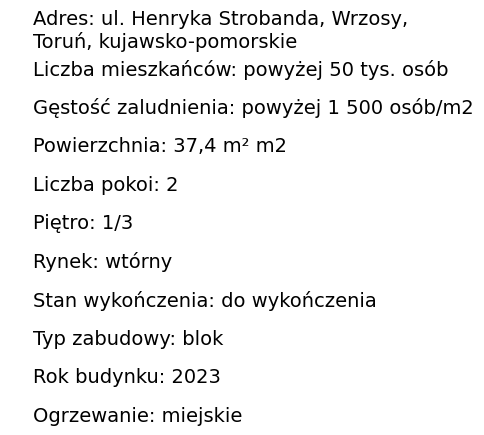

In [ ]:
info_obj = data_for_showing(data_initial.iloc[0], data_for_analysis.iloc[0])
plt.show(info_obj)

# Apartment location

In [7]:
def prepare_address_string(address_str):
    
    """
    Cleans and standardizes an address string by removing common street prefixes 
    and reducing redundant whitespace.

    This function is particularly useful for ensuring address consistency 
    when performing string comparisons, matching, or geocoding.

    Operations performed:
    - Removes common Polish street prefixes (e.g., "ul.", "ulica", "Ul", etc.).
    - Collapses multiple spaces into a single space.

    Parameters:
    -----------
    address_str : str
        The original address string to clean and normalize.

    Returns:
    --------
    address_str : str
        The cleaned and standardized address string.
    """
    
    # Define unwanted prefixes to remove from address string
    substrings_to_delete = ("ulica ", "Ulica ", "ul. ", "ul ", "Ul. ", "Ul ", "ul.")
    
     # Remove each defined prefix from the string
    for substring in substrings_to_delete:
        address_str = address_str.replace(substring, "")

    # Remove multiple spaces
    address_str = " ".join(address_str.split())
    
    return address_str

In [8]:
def get_location(address_str, retries=3):
    
    """
    Attempts to geocode a given address string using the Nominatim geolocation service,
    applying several variations of the address format to improve matching success.

    This function cleans the input address, generates possible simplified versions,
    and tries to geocode each of them. It's especially useful for handling inconsistent
    or verbose address formats (e.g., from real-world datasets).

    Parameters:
    -----------
    address_str : str
        The full address string to geocode.
        
    retries : int, optional (default=3)
        Number of retry attempts in case of timeouts from the geolocation service.

    Returns:
    --------
    tuple or None
        Returns a tuple (latitude, longitude) if the address is successfully geocoded,
        otherwise returns None if all attempts fail.
    """

    # Initialize Nominatim geocoder
    geolocator = Nominatim(user_agent="geo_folium_app")
    
    # Clean address
    original_address = prepare_address_string(address_str)
    
    # List of address variations to try
    address_variations = [original_address]

    # Attempt to extract city name based on capitalized words (heuristic)o
    city_name = re.findall(r'\b[A-ZŚĆŁŹŻĄĘÓŃ][a-ząćęłńóśźżA-ZŚĆŁŹŻĄĘÓŃ]*\b', original_address)
    city_name = city_name[-1] if city_name else ""
    
    # Generate address variations if the address contains multiple comma-separated parts
    parts = original_address.split(", ")
    if len(parts) > 2:
        for i in range(len(parts)-1):
            street_name = parts[i]
            address_variations.append(f"{street_name}, {city_name}")
        
            # Handle cases where streets contain multiple names separated by slashes
            pattern = r"(?<=\b\w)/(?=\w\b)"
            if re.search(pattern, parts[i]):
                street_name = parts[i].split("/")[0]
                address_variations.append(f"{street_name}, {city_name}")
            
             # Attempt simplification by using only the last word of a long street name
            if (len(parts[i])>20 and " " in parts[i]):
                street_name = parts[i].split(" ")[-1]
                address_variations.append(f"{street_name}, {city_name}")
    
    # Add a fallback using city and last part (e.g., region)
    address_variations.append(f"{city_name}, {parts[-1]}") 

    # Try geocoding each variation with retry logic
    for attempt in range(retries):
        for address in address_variations:
            try:
                location = geolocator.geocode(address)
                if location:
                    return location.latitude, location.longitude
            except GeocoderTimedOut:
                print(f"Timeout for address: {address}, retrying...")

    print("The address could not be found")
    
    return None  # Return None if all attempts fail

In [9]:
def show_location(address_str):
    
    """
    Visualizes the geographic location of a given address using Folium.

    This function first attempts to geocode the provided address string using the
    `get_location` function (which internally uses Nominatim). If a valid location
    is found, it renders an interactive map with a marker pointing to the location.

    It is particularly useful for quickly validating address resolution and
    visualizing spatial data in a Jupyter notebook environment.

    Parameters:
    -----------
    address_str : str
        A textual representation of the address to geocode and map.

    Returns:
    --------
    folium.Map or None
        A Folium map object with a marker at the resolved location if successful;
        otherwise, prints a message and returns None.
    """
    
    # Initialize geocoder
    geolocator = Nominatim(user_agent="geo_folium_app")

    # Get location
    location = get_location(address_str)

    # Check if location was found
    if location:
        lat, lon = location[0], location[1]

        # Create a folium map centered at the location
        map_obj = folium.Map(location=[lat, lon], zoom_start=14)

        # Add a marker for the location
        folium.Marker([lat, lon],
                      popup = address_str,
                      tooltip="Click for info").add_to(map_obj)

        # Display map inline in the notebook
        return map_obj

    else:
        print("Location not found.")

In [ ]:
# it was checked if for the first 100 addresses it was possible to find addresses
for i in range(100):
    get_location(data_initial['address'][i])

In [14]:
map_obj = show_location(data_initial.iloc[0]["address"])
map_obj

# Complete apartment info report

In [17]:
def run_display(info_obj, map_obj):
    
    tmpfile_info = BytesIO()
    info_obj.savefig(tmpfile_info, format='png')
    plt.close()
    tmpfile_info.seek(0)
    plt.close()

    map_html = map_obj._repr_html_()

    image_widget = widgets.Image(value=tmpfile_info.getvalue(), format='png',
                                 layout = widgets.Layout(width='100%', height='60%'))
    html_widget = widgets.HTML(value=map_html,
                               layout = widgets.Layout(width='100%', height='40%'))

    display(widgets.VBox([image_widget, html_widget]))

In [19]:
info_obj = data_for_showing(data_initial.iloc[0], data_for_analysis.iloc[0])
map_obj = show_location(data_initial.iloc[0]["address"])
run_display(info_obj, map_obj)